In [2]:
from xgboost import XGBClassifier, cv
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost
from joblib import dump, load
from datetime import datetime
import matplotlib.pyplot as plt


train_df = gpd.read_file("train.geojson", index_col=0)
test_df = gpd.read_file("test.geojson", index_col=0)

In [40]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

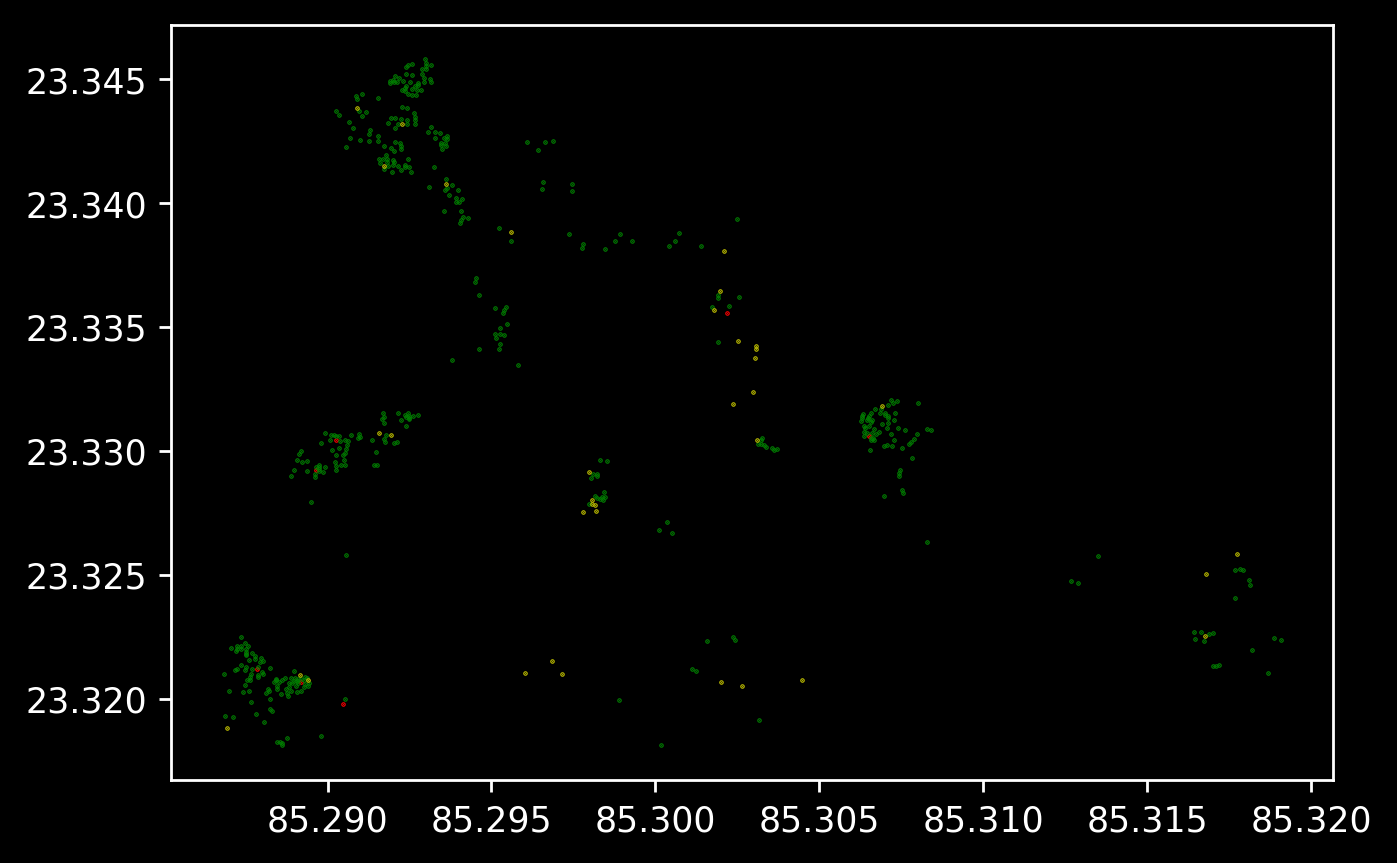

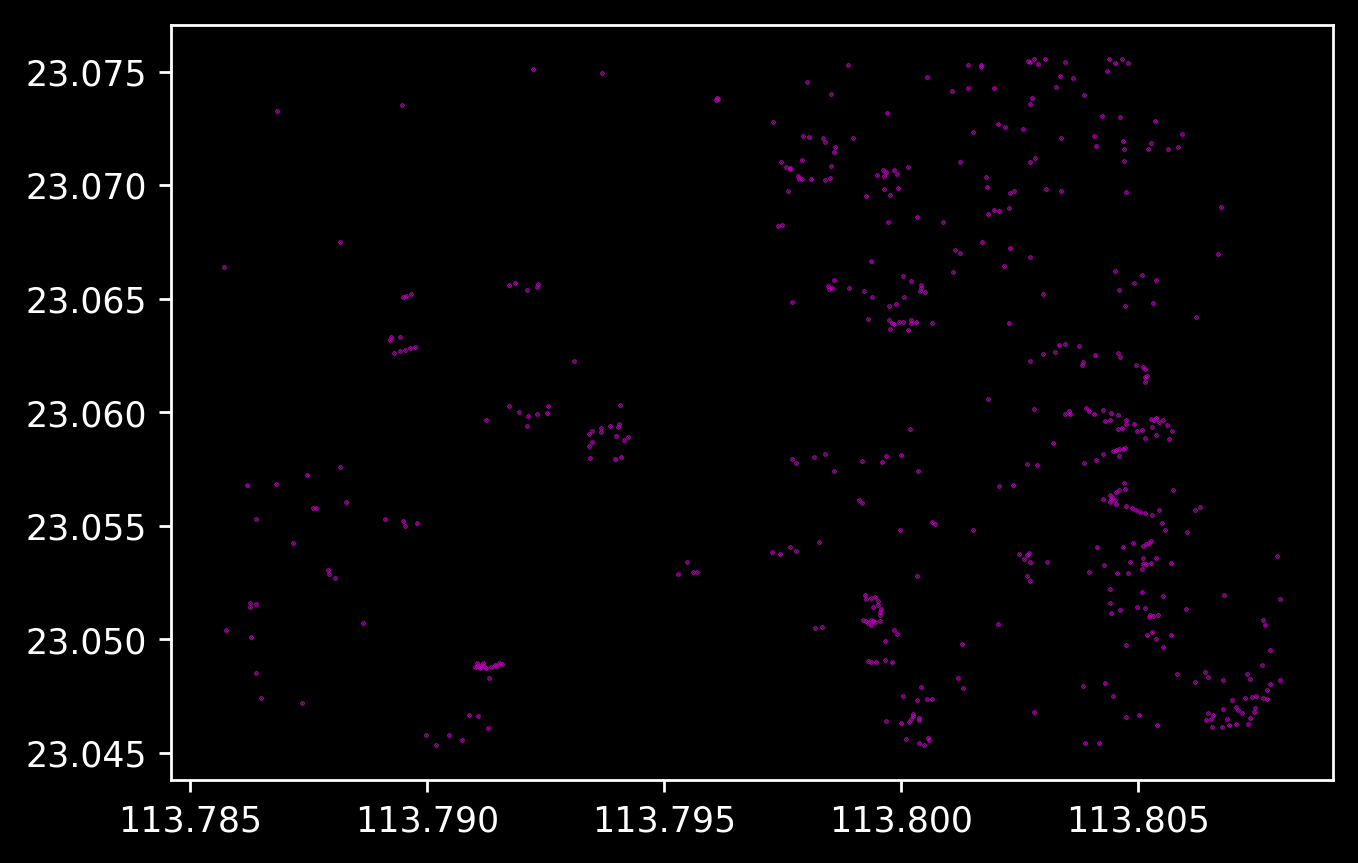

In [103]:
change_type_map = {
    "Demolition": 0,
    "Road": 1,
    "Residential": 2,
    "Commercial": 3,
    "Industrial": 4,
    "Mega Projects": 5,
}

colors = ['r','b','g','y','c','w']

plt.style.use('dark_background')
N = 10000
K = 500
X = train_df[N:N + K]
for category, i in change_type_map.items():
    X_feature = X[X['change_type'] == category]
    geometry = X_feature['geometry']
    L_x = geometry.apply(lambda x : x.boundary.centroid.x)
    L_y = geometry.apply(lambda x : x.boundary.centroid.y)
    plt.scatter(L_x, L_y, s = 0.1, color = colors[i])
plt.show()

X_feature = test_df[N:N+K]
geometry = X_feature['geometry']
L_x = geometry.apply(lambda x : x.boundary.centroid.x)
L_y = geometry.apply(lambda x : x.boundary.centroid.y)

plt.scatter(L_x, L_y, s = 0.1, color = 'm')
plt.show()


In [ ]:

change_type_map = {
    "Demolition": 0,
    "Road": 1,
    "Residential": 2,
    "Commercial": 3,
    "Industrial": 4,
    "Mega Projects": 5,
}

colors = ['r','b','g','y','c','w']

plt.style.use('dark_background')
N = 10000
X = train_df[N:N + 100]
for category, i in change_type_map.items():
    X_feature = X[X['change_type'] == category]
    geometry = X_feature['geometry']
    L_x = geometry.apply(lambda x : x.boundary.centroid.x)
    L_y = geometry.apply(lambda x : x.boundary.centroid.y)
    
    a=X_feature.iloc[:]
    plt.scatter(L_x, L_y, s = 0.1, color = colors[i])
    a.plot()


<AxesSubplot:>

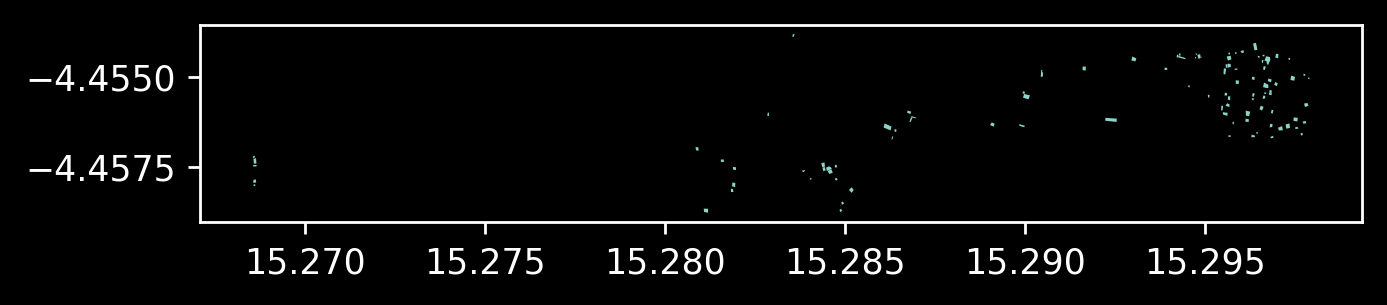

In [53]:

N = 30000
a=train_df.iloc[N:N+100]
a.plot()

In [3]:
train_5=train_df[train_df['change_type']=='Mega Projects']
print(train_5.head())
print(train_5.shape[0])
print(np.unique(train_5['urban_types']))

       index    change_type change_status_date1 change_status_date2  \
12761  12761  Mega Projects           Greenland           Greenland   
17961  17961  Mega Projects           Greenland           Greenland   
22612  22612  Mega Projects  Prior Construction  Prior Construction   
24579  24579  Mega Projects           Greenland           Greenland   
24651  24651  Mega Projects        Land Cleared           Greenland   

      change_status_date3 change_status_date4 change_status_date5       date1  \
12761        Land Cleared        Land Cleared           Greenland  17-02-2014   
17961           Greenland   Construction Done   Construction Done  15-04-2015   
22612        Land Cleared   Construction Done   Construction Done  15-04-2014   
24579           Greenland        Land Cleared   Construction Done  05-12-2013   
24651           Greenland   Construction Done   Construction Done  05-12-2013   

            date2       date3       date4       date5  urban_types  \
12761  20-11-201

In [4]:
train_0=train_df[train_df['change_type']=='Demolition']
print(train_0.head())
print(train_0.shape[0])
print(len(np.unique(train_0['date1'])))

     index change_type  change_status_date1  change_status_date2  \
348    348  Demolition   Prior Construction   Prior Construction   
365    365  Demolition   Prior Construction         Land Cleared   
495    495  Demolition   Prior Construction            Greenland   
669    669  Demolition   Prior Construction         Land Cleared   
689    689  Demolition  Construction Midway  Construction Midway   

    change_status_date3 change_status_date4 change_status_date5       date1  \
348           Greenland           Greenland           Greenland  09-05-2015   
365           Greenland           Greenland           Greenland  09-05-2015   
495           Greenland           Greenland           Greenland  09-05-2015   
669           Greenland           Greenland        Land Cleared  09-05-2015   
689           Greenland           Greenland           Greenland  09-05-2015   

          date2       date3       date4       date5   urban_types  \
348  06-11-2016  19-11-2017  25-10-2018  01-12-

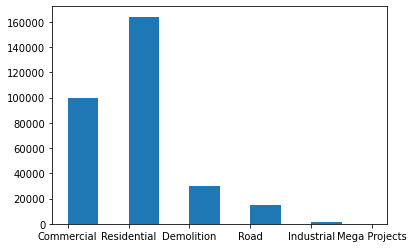

In [5]:
plt.hist(train_df['change_type'].values)
plt.show()

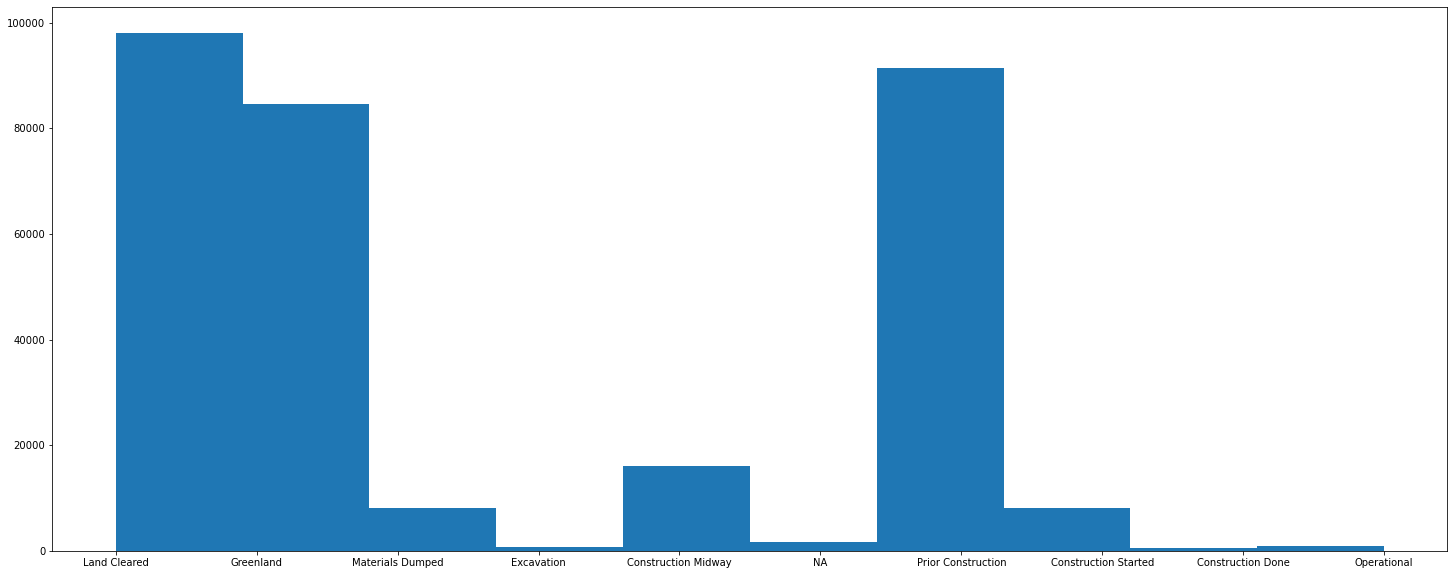

In [6]:
plt.figure(figsize=(25,10))
plt.hist(train_df['change_status_date1'].values)
plt.show()

In [7]:
print(len([x for x in train_df['change_status_date1'].values if x=='Excavation']))

626


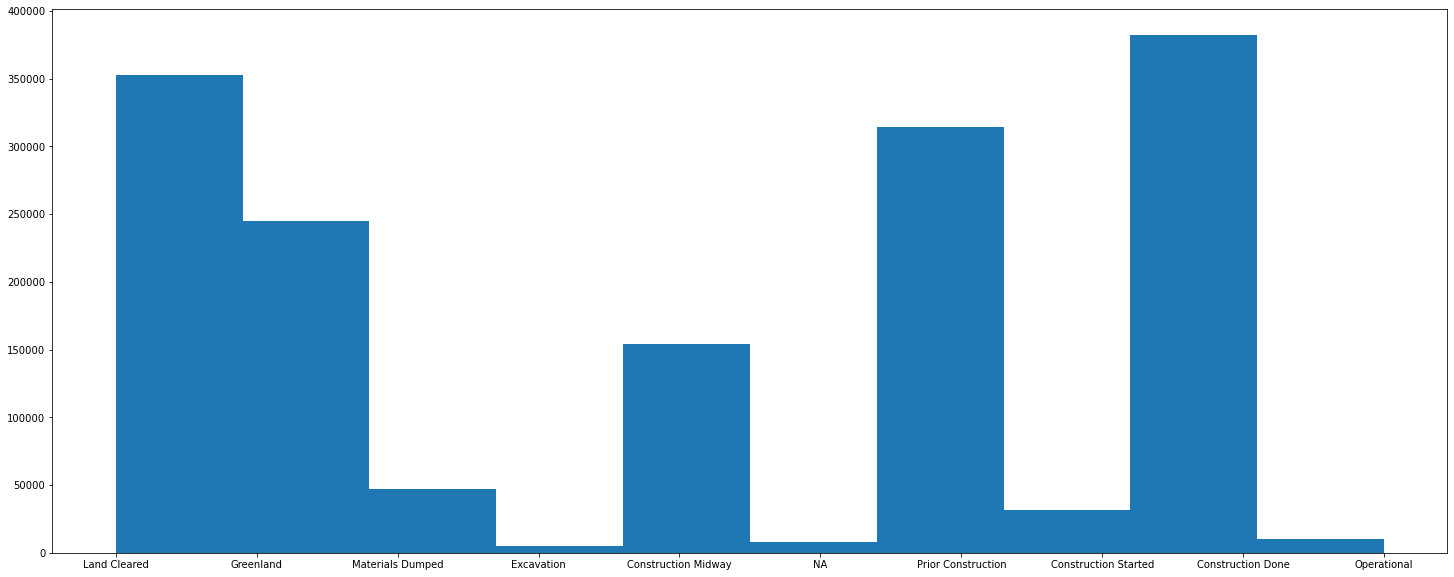

In [8]:

v=list(train_df['change_status_date1'].values)+list(train_df['change_status_date2'].values)+list(train_df['change_status_date3'].values)+list(train_df['change_status_date4'].values)+list(train_df['change_status_date5'].values)
plt.figure(figsize=(25,10))
plt.hist(v)
plt.show()

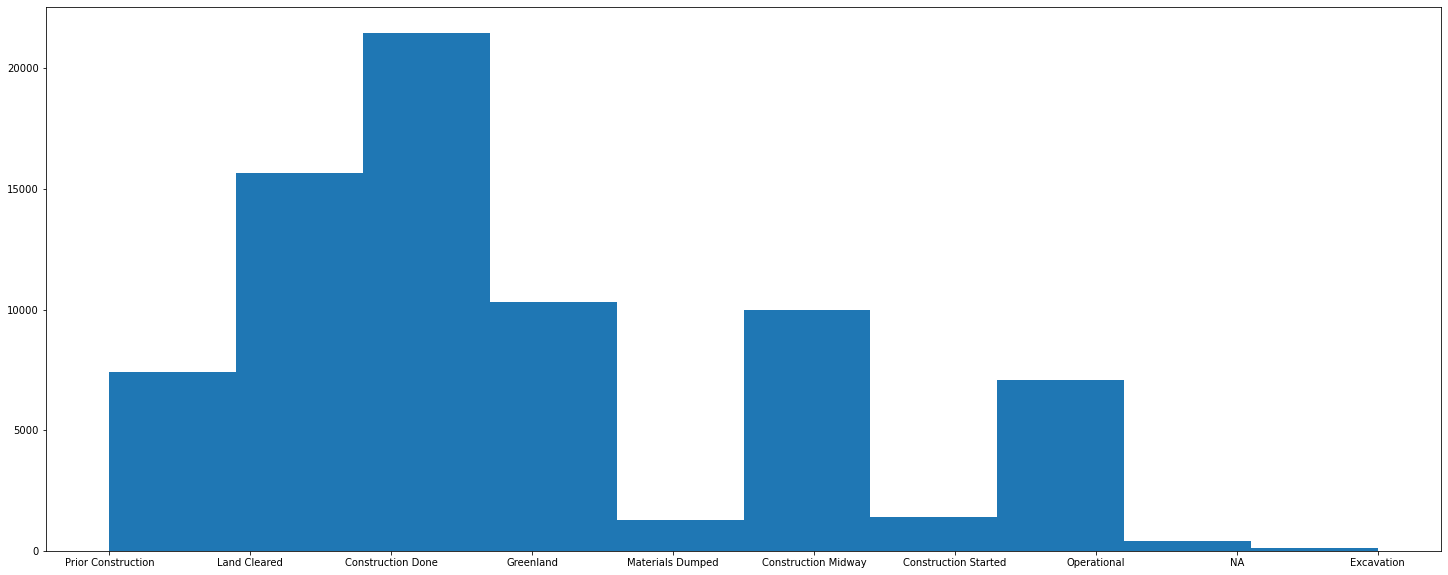

5


In [96]:
train_5=train_df[train_df['change_type']=='Road']
v=list(train_5['change_status_date1'].values)+list(train_5['change_status_date2'].values)+list(train_5['change_status_date3'].values)+list(train_5['change_status_date4'].values)+list(train_5['change_status_date5'].values)
plt.figure(figsize=(25,10))
plt.hist(v)
plt.show()
print(len([x for x in train_5['change_status_date5'].values if x=='Excavation']))

In [10]:
t=train_df.drop(train_df[(train_df['change_status_date1']=='Na') | (train_df['change_status_date2']=='Na') | (train_df['change_status_date3']=='Na') | (train_df['change_status_date4']=='Na') | (train_df['change_status_date5']=='Na') ].index)
print(t.head())

   index change_type change_status_date1  change_status_date2  \
0      0  Commercial        Land Cleared  Construction Midway   
1      1  Commercial           Greenland            Greenland   
2      2  Commercial        Land Cleared         Land Cleared   
3      3  Commercial        Land Cleared         Land Cleared   
4      4  Commercial        Land Cleared         Land Cleared   

    change_status_date3  change_status_date4 change_status_date5       date1  \
0     Construction Done    Construction Done   Construction Done  29-05-2014   
1     Construction Done    Construction Done   Construction Done  29-05-2014   
2     Construction Done    Construction Done   Construction Done  29-05-2014   
3   Construction Midway  Construction Midway   Construction Done  29-05-2014   
4  Construction Started  Construction Midway   Construction Done  29-05-2014   

        date2       date3       date4       date5   urban_types  \
0  13-09-2015  25-02-2017  10-10-2018  19-05-2020    Industri

In [69]:
train_df["area"] = train_df["geometry"].area
train_df["length"] = train_df["geometry"].length

# a = train_df["area"]
# b = train_df["length"]
# train_df["area"] = (a - a.min()) / (a.max() - a.min())
# train_df["length"] = (b - b.min()) / (b.max() - b.min())

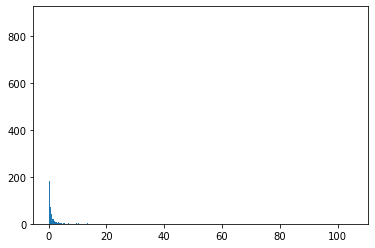

1.1284301463192679
5.1567863010736055
105.27613197195323
0.0038594830190772094


In [59]:
plt.hist(train_df["area"][(train_df["change_type"]=='Industrial')],bins=500)
plt.show()
print(train_df["area"][(train_df["change_type"]=='Industrial')].mean())
print(train_df["area"][(train_df["change_type"]=='Industrial')].std())
print(train_df["area"][(train_df["change_type"]=='Industrial')].max())
print(train_df["area"][(train_df["change_type"]=='Industrial')].min())

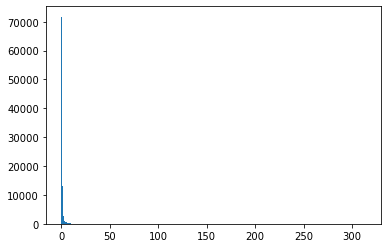

0.8286730466866911
2.5881417817095422
313.9164273617192
0.001439301897018818


In [56]:
plt.hist(train_df["area"][(train_df["change_type"]=='Commercial')],bins=500)
plt.show()
print(train_df["area"][(train_df["change_type"]=='Commercial')].mean())
print(train_df["area"][(train_df["change_type"]=='Commercial')].std())
print(train_df["area"][(train_df["change_type"]=='Commercial')].max())
print(train_df["area"][(train_df["change_type"]=='Commercial')].min())

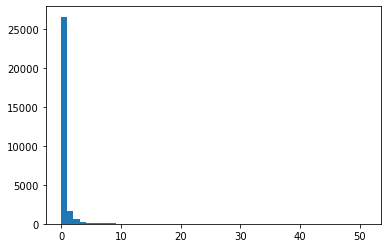

0.5963680665954294
1.8876634101781136
51.001239159423555
0.001895830467551964


In [54]:
plt.hist(train_df["area"][(train_df["change_type"]=='Demolition')],bins=50)
plt.show()
print(train_df["area"][(train_df["change_type"]=='Demolition')].mean())
print(train_df["area"][(train_df["change_type"]=='Demolition')].std())
print(train_df["area"][(train_df["change_type"]=='Demolition')].max())
print(train_df["area"][(train_df["change_type"]=='Demolition')].min())

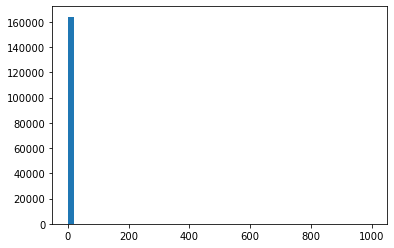

0.309418360755138
3.1880807688253388
1000.0
0.0
[0.00000000e+00 8.14105136e-04 9.46285827e-04 ... 4.13647306e+02
 5.62947299e+02 1.00000000e+03]


In [53]:
plt.hist(train_df["area"][(train_df["change_type"]=='Residential')],bins=50)
plt.show()
print(train_df["area"][(train_df["change_type"]=='Residential')].mean())
print(train_df["area"][(train_df["change_type"]=='Residential')].std())
print(train_df["area"][(train_df["change_type"]=='Residential')].max())
print(train_df["area"][(train_df["change_type"]=='Residential')].min())

print(np.unique(train_df["area"][(train_df["change_type"]=='Residential')]))

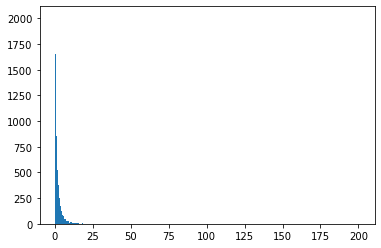

2.1876185846906298
4.869102886053712


In [47]:
plt.hist(train_df["area"][(train_df["change_type"]=='Road')],bins=1000)
plt.show()
print(train_df["area"][(train_df["change_type"]=='Road')].mean())
print(train_df["area"][(train_df["change_type"]=='Road')].std())

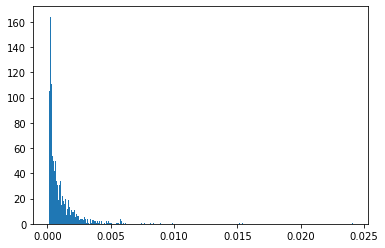

0.0011242425857468951
0.001550172389432484
0.024107789269069153
9.250219195509492e-05


In [55]:
plt.hist(train_df["length"][(train_df["change_type"]=='Industrial')],bins=500)
plt.show()
print(train_df["length"][(train_df["change_type"]=='Industrial')].mean())
print(train_df["length"][(train_df["change_type"]=='Industrial')].std())
print(train_df["length"][(train_df["change_type"]=='Industrial')].max())
print(train_df["length"][(train_df["change_type"]=='Industrial')].min())

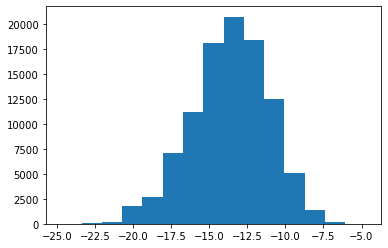

In [93]:
from scipy.stats import boxcox

train_df['boxcox_length'],param=boxcox(train_df['length'])

plt.hist(train_df["boxcox_length"][(train_df["change_type"]=='Commercial')],bins=15)
plt.show()

In [112]:
train_df["diff1"] = (
    train_df["date2"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    - train_df["date1"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
).apply(lambda x: x.days)
train_df["diff2"] = (
    train_df["date3"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    - train_df["date2"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
).apply(lambda x: x.days)
train_df["diff3"] = (
    train_df["date4"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    - train_df["date3"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
).apply(lambda x: x.days)
train_df["diff4"] = (
    train_df["date5"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    - train_df["date4"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
).apply(lambda x: x.days)


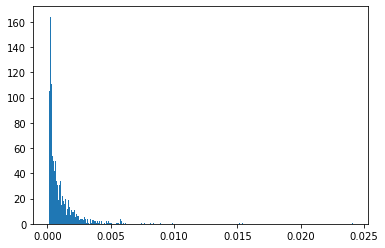

In [113]:
plt.hist(train_df["length"][(train_df["change_type"]=='Industrial')],bins=500)
plt.show()

<AxesSubplot:>

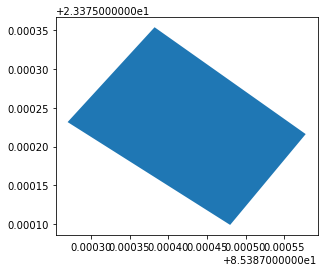

In [129]:
a=train_df[train_df['change_type']=='Demolition'].iloc[0:1]
a.plot()

<AxesSubplot:>

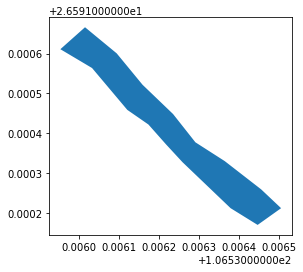

In [139]:
a=train_df[train_df['change_type']=='Road'].iloc[100:101]
a.plot()

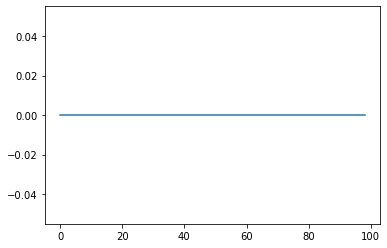

In [155]:
def opt(threshold):
    train_df["area"] = train_df["geometry"].area
    u=train_df["area"].values
    train_df["length"] = train_df["geometry"].length
    v=train_df["length"].values
    roads_area=train_df[train_df['change_type']=='road'].area.values
    roads_length=train_df[train_df['change_type']=='road'].length.values
    p=roads_length.shape[0]
    n=v.shape[0]
    tot=0
    k=0
    for i in range(p):
        if roads_area[i]/roads_length[i]<threshold:
            tot+=1
            if train_df['change_type'].iloc[i]=='road':
                k+=1
    return k/tot

li=[opt(i/100) for i in range(1,100)]
plt.plot(li)
plt.show()

    

<AxesSubplot:>

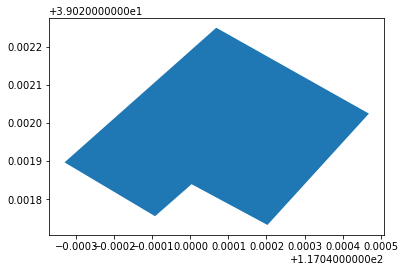

In [130]:
a=train_df[train_df['change_type']=='Commercial'].iloc[1020:1021]
a.plot()

<AxesSubplot:>

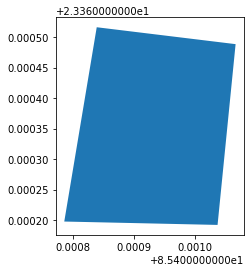

In [131]:
a=train_df[train_df['change_type']=='Residential'].iloc[1050:1051]
a.plot()

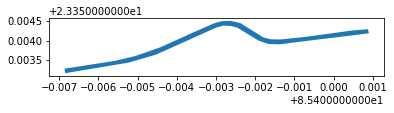

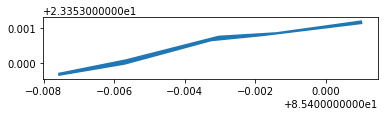

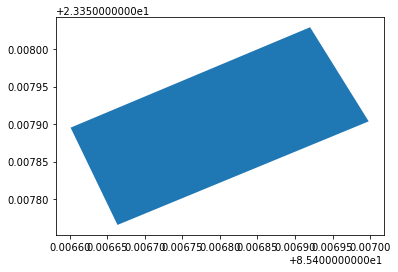

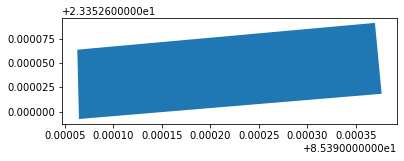

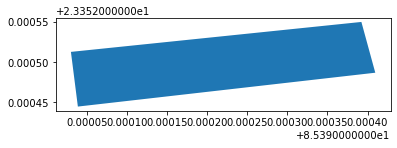

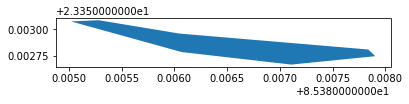

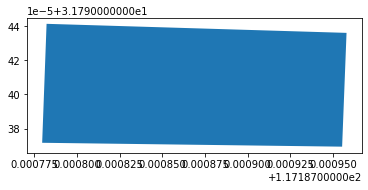

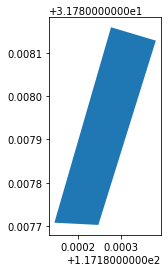

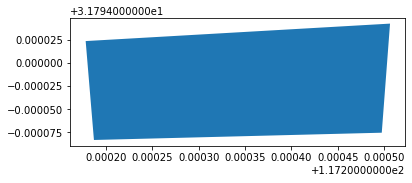

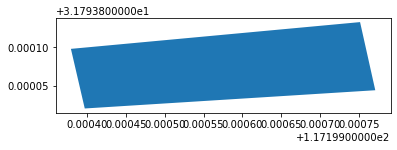

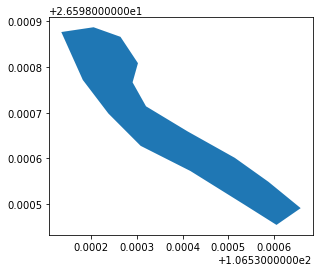

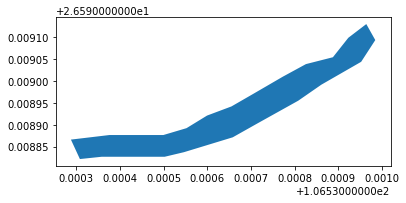

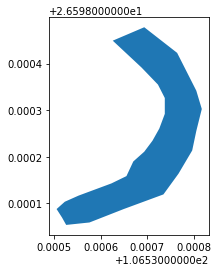

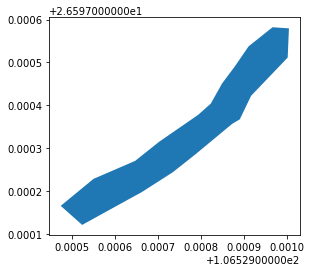

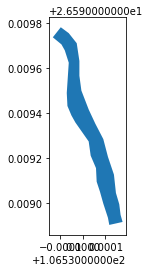

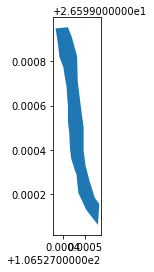

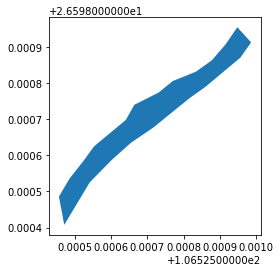

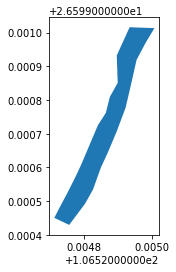

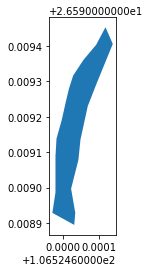

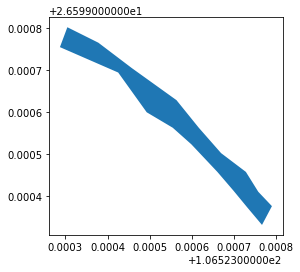

In [45]:
for i in range(20):
    a=train_df[train_df['change_type']=='Road'].iloc[i:i+1]
    a.plot()

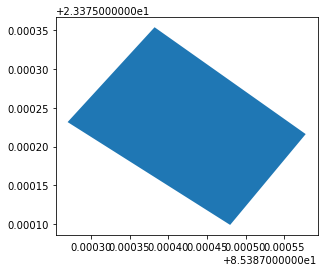

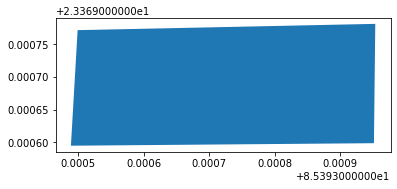

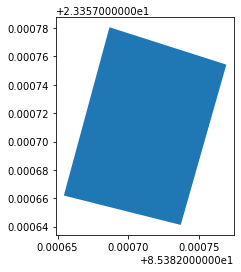

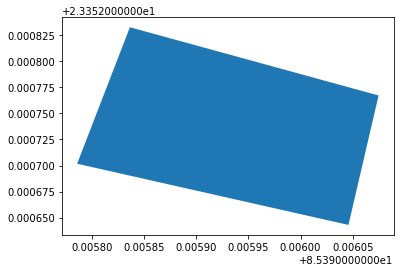

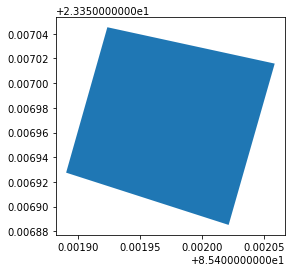

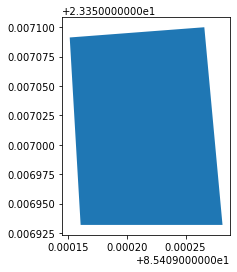

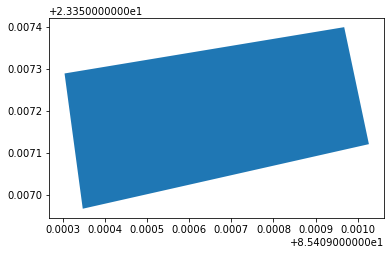

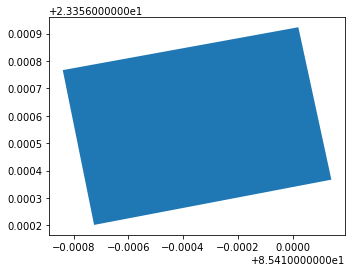

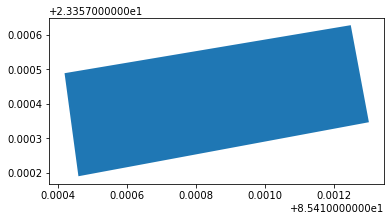

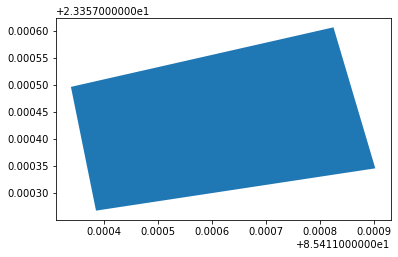

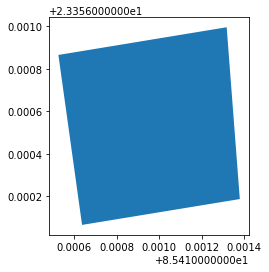

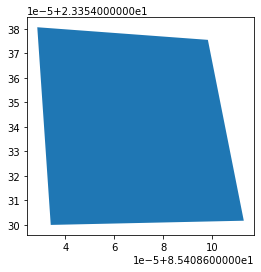

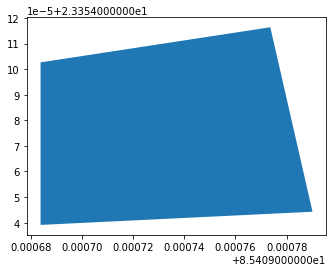

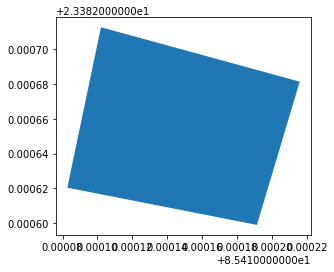

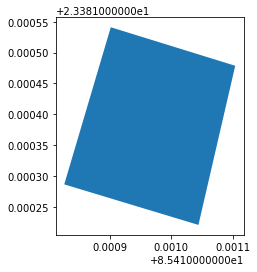

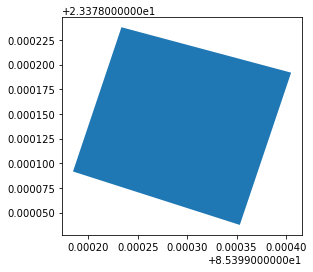

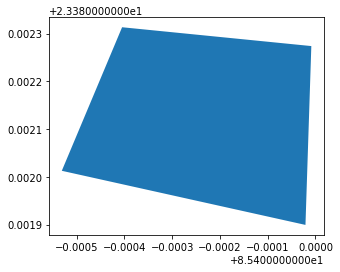

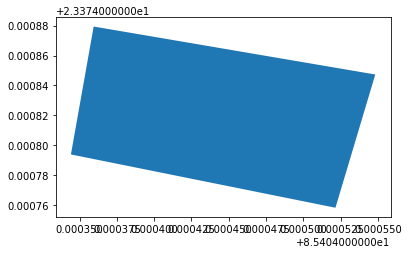

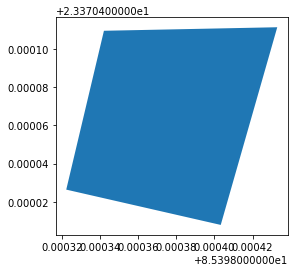

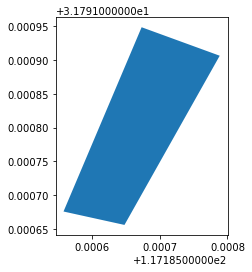

In [31]:
for i in range(20): 
    a=train_df[train_df['change_type']=='Demolition'].iloc[i:i+1]
    a.plot()

In [28]:
print(train_df['geometry'].boundary)


0         LINESTRING (116.97563 38.89002, 116.97590 38.8...
1         LINESTRING (116.97500 38.88969, 116.97524 38.8...
2         LINESTRING (116.97519 38.88847, 116.97568 38.8...
3         LINESTRING (116.97630 38.89017, 116.97730 38.8...
4         LINESTRING (116.97751 38.89037, 116.97854 38.8...
                                ...                        
310001    LINESTRING (139.80642 35.60416, 139.80597 35.6...
310002    LINESTRING (139.80857 35.60407, 139.80831 35.6...
310003    LINESTRING (139.80927 35.60445, 139.80889 35.6...
310004    LINESTRING (139.80688 35.60937, 139.80645 35.6...
310005    LINESTRING (139.80765 35.60978, 139.80725 35.6...
Length: 310006, dtype: geometry


In [62]:
train_df["area"] = train_df["geometry"].area
train_df["length"] = train_df["geometry"].length

train_df["area/length**2"] = train_df["length"]**2/train_df["area"]


In [133]:
k=0
b= train_df[train_df["change_type"]=="Commercial"]["geometry"].boundary
n=1000
for i in range(n):
    pt=list(b.iloc[i].coords)
    pt1=max(pt,key=lambda x:x[1])   # point with maximal ordinate
    pt2=min(pt,key=lambda x:x[1])   # point with minimal ordinate
    if pt2[0]<pt1[0]:
        k+=1
print(k/n)

0.597


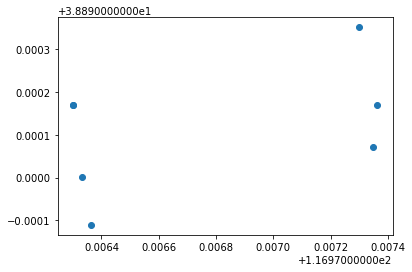

<AxesSubplot:>

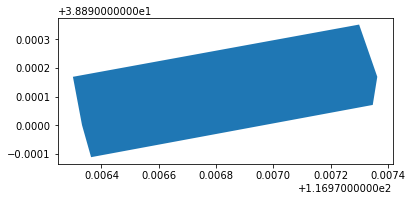

In [96]:

pts=b.iloc[0].coords


abs=[x[0] for x in pts]
ord=[x[1] for x in pts]

plt.scatter(abs,ord)
plt.show()

train_df.iloc[3:4].plot()

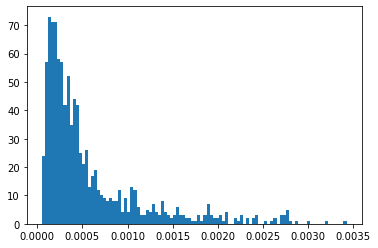

In [143]:
b= train_df[train_df["change_type"]=="Commercial"]["geometry"].boundary
l=[]
for i in range(n):
    pt=list(b.iloc[i].coords)
    pt1=max(pt,key=lambda x:x[1])   # point with maximal ordinate
    pt2=min(pt,key=lambda x:x[1])   # point with minimal ordinate
    pt3=max(pt,key=lambda x:x[0])   # point with maximal abscissa
    pt4=min(pt,key=lambda x:x[0])   # point with minimal abscissa
    l.append(max(pt1[1]-pt2[1],pt3[0]-pt4[0]))
plt.hist(l,bins=100)
plt.show()


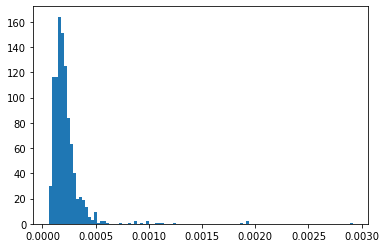

In [144]:
b= train_df[train_df["change_type"]=="Residential"]["geometry"].boundary
l=[]
for i in range(n):
    pt=list(b.iloc[i].coords)
    pt1=max(pt,key=lambda x:x[1])   # point with maximal ordinate
    pt2=min(pt,key=lambda x:x[1])   # point with minimal ordinate
    pt3=max(pt,key=lambda x:x[0])   # point with maximal abscissa
    pt4=min(pt,key=lambda x:x[0])   # point with minimal abscissa
    l.append(max(pt1[1]-pt2[1],pt3[0]-pt4[0]))
plt.hist(l,bins=100)
plt.show()


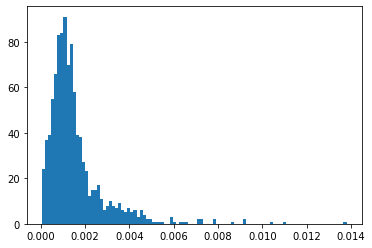

In [145]:
b= train_df[train_df["change_type"]=="Road"]["geometry"].boundary
l=[]
for i in range(n):
    pt=list(b.iloc[i].coords)
    pt1=max(pt,key=lambda x:x[1])   # point with maximal ordinate
    pt2=min(pt,key=lambda x:x[1])   # point with minimal ordinate
    pt3=max(pt,key=lambda x:x[0])   # point with maximal abscissa
    pt4=min(pt,key=lambda x:x[0])   # point with minimal abscissa
    l.append(max(pt1[1]-pt2[1],pt3[0]-pt4[0]))
plt.hist(l,bins=100)
plt.show()
